神经网络反向传播
======
实现神经网络的反向传播算法，并将其应用于手写数字(从0到9)识别任务。

数据：数据以.mat格式储存，mat格式是matlab的数据存储格式，按照矩阵保存，与numpy数据格式兼容，适合于各种数学运算，因此主要使用numpy进行运算。

ex3data1中有5000个训练样例，其中每个训练样例是一个20像素×20像素灰度图像的数字，每个像素由一个浮点数表示，该浮点数表示该位置的灰度强度。每个20×20像素的网格被展开成一个400维的向量。这些每个训练样例都变成数据矩阵X中的一行。这就得到了一个5000×400矩阵X，其中每一行都是手写数字图像的训练样例。

训练集的第二部分是一个包含训练集标签的5000维向量y，“0”的数字标记为“10”，而“1”到“9”的数字按自然顺序标记为“1”到“9”。


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp

np.set_printoptions(suppress=True, precision=6, floatmode='fixed')
## 全局设置
plt.rcParams['figure.figsize']=(8, 8)
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

# 神经网络每层的神经元:
input_layer_size = 400  # 可以把 X 看作特殊的神经元
hidden_layer_size = 25  # 25 个神经元
num_labels = 10         # 10 个神经元, 对应 0 ~ 9的概率


# 读取数据：

sio.loadmat 读取mat后，为dict类型

In [18]:
import scipy.io
data = scipy.io.loadmat('ex4data1.mat')


In [19]:
print(type(data))
print(data.keys())
print(data['X'].shape)
print(data['y'].shape)
print(data['y'])


<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(5000, 400)
(5000, 1)
[[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]


# 读入训练好的权重

In [20]:
weights = scipy.io.loadmat('ex4weights.mat')

print(weights.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])


In [21]:
Theta1 = weights['Theta1'] # 第1层的权重 (中的隐藏层 25个神经元) 维度: 25 * 401
Theta2 = weights['Theta2'] # 第2层的权重 (输出层 10个神经元)     维度: 10 * 26

print(Theta1.shape, Theta2.shape)


(25, 401) (10, 26)


# theta 系列化和反系列化

在 Neural Network 中因为有多个层, 每一层的每一个Neuron(神经元)都有一个theta向量, 因此每一层的theta是一个矩阵, 维度是 `(当前层的神经元个数 * 前一层神经元个数)`.

梯度下降优化器要求传入的theta 是一个扁平的数组, 因此我们需要想办法把所有层的theta矩阵展开传入优化器, 同时又可以根据网络的层数和每一层的神经元个数反推出每一层的theta 矩阵.

所以我们引入了系列化和反系列化.

In [22]:
def serialize(a, b):
    return np.append(a.flatten(), b.flatten())

def deserialize(serializedThetas):
    theta1 = serializedThetas[:hidden_layer_size * (input_layer_size + 1)]
    theta2 = serializedThetas[hidden_layer_size * (input_layer_size + 1):]
    theta1 = theta1.reshape((hidden_layer_size, input_layer_size + 1))
    theta2 = theta2.reshape((num_labels, hidden_layer_size + 1))
    return theta1, theta2

serialized_Trained_Thetas = serialize(Theta1, Theta2)
print(serialized_Trained_Thetas.shape)

a, b = deserialize(serialized_Trained_Thetas)
print(a.shape, b.shape)


(10285,)
(25, 401) (10, 26)


# 构建数据集

In [23]:
X = data['X']
y = data['y'] - 1 # data 中y 范围是1~10, 代表数字0~9, 故减1
y_raw = y
print(X.shape)
print(y.shape)
print(y)


(5000, 400)
(5000, 1)
[[9]
 [9]
 [9]
 ...
 [8]
 [8]
 [8]]


## 对 y 进行One-Hot 编码

In [24]:
def oneHot(y, k=10):
    return np.eye(k)[y[:, 0]]

y = oneHot(data['y'] - 1)  # data['y'] 范围是 1 ~ 10
print(y[:5], y.shape)


[[0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000 1.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000 1.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000 1.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000 1.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
  0.000000 1.000000]] (5000, 10)


# 实现前向传播


In [25]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def feedForward(serializedThetas, X):
    theta1, theta2 = deserialize(serializedThetas)

    # 第1层: 隐藏层, 有25个神经元, theta1 (25, 401)
    a0 = np.insert(X, 0, values=1, axis=1) # 给bias 增加一列 1
    z1 = a0 @ theta1.T  # (5000, 401) (401, 25) => (5000,25)
    a1 = sigmoid(z1)

    # 第2层: 输出层, 有10个神经元, theta2 (10, 26)
    a1 = np.insert(a1, 0, values=1, axis=1) # 给bias 增加一列 1
    z2 = a1 @ theta2.T # (5000,26) (26, 10) => (5000,10)
    a2 =sigmoid(z2) # 输出h为1的概率

    return a0, z1, a1, z2, a2


def feedForward_new(X, thetas):
    '''
    遍历 thetas 列表, 进行前向传播
    '''
    a = X
    for theta in thetas:
        a = np.insert(a, 0, values=1, axis=1) # 给bias 增加一列 1
        z = a @ theta.T
        a = sigmoid(z)

    h_argmax = np.argmax(a, axis=1) # 按行返回概率最大的索引, 对应数字0 ~ 9
    return h_argmax[:, np.newaxis] # 维度变为 (xxx,1)


# 神经网络的损失函数和梯度

## 损失算法

本练习的网络损失公式:
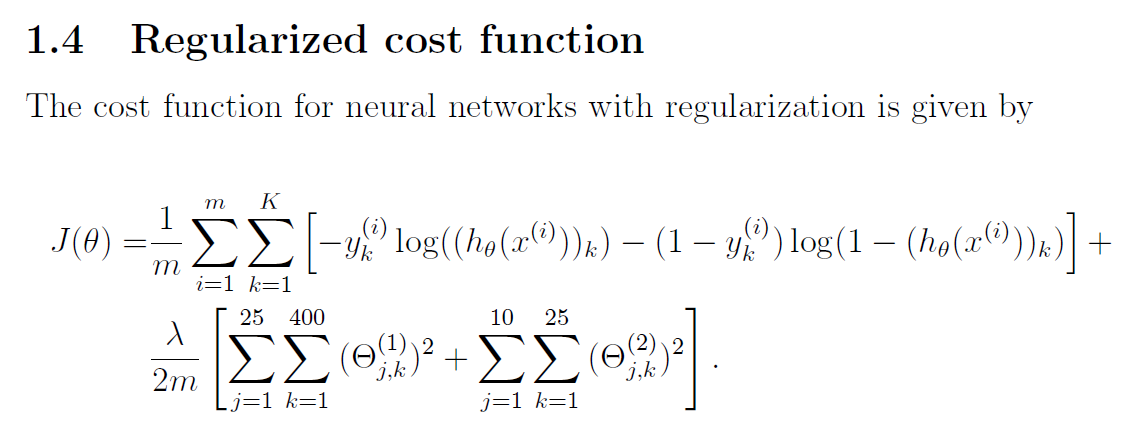

网络损失公式:
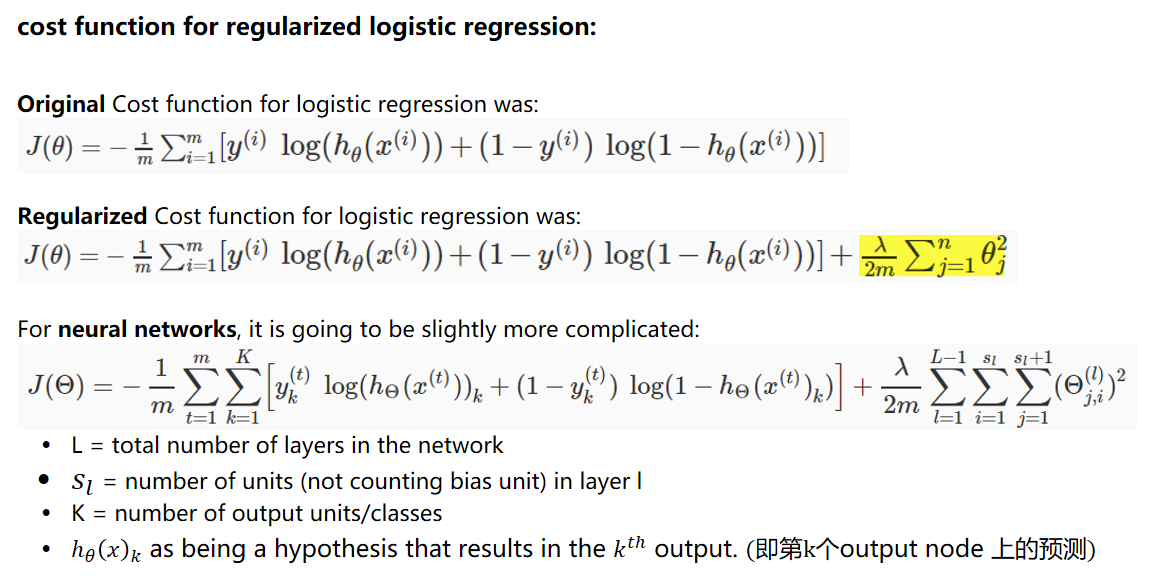

## 梯度算法

网络梯度公式:
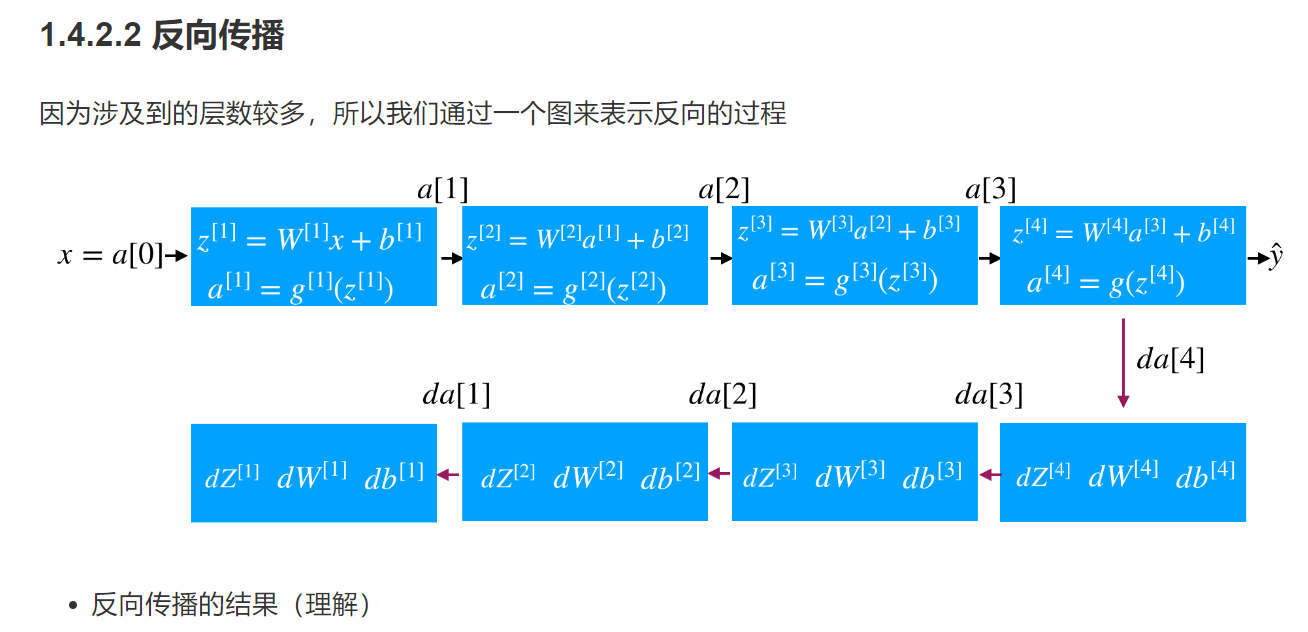

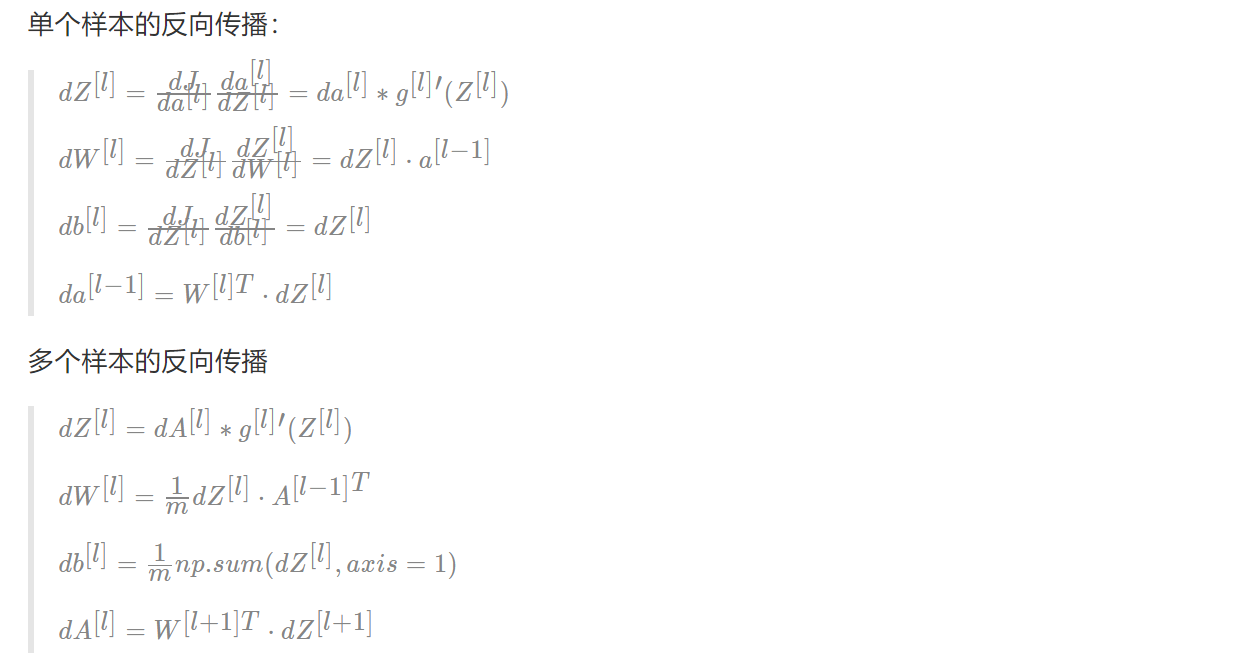

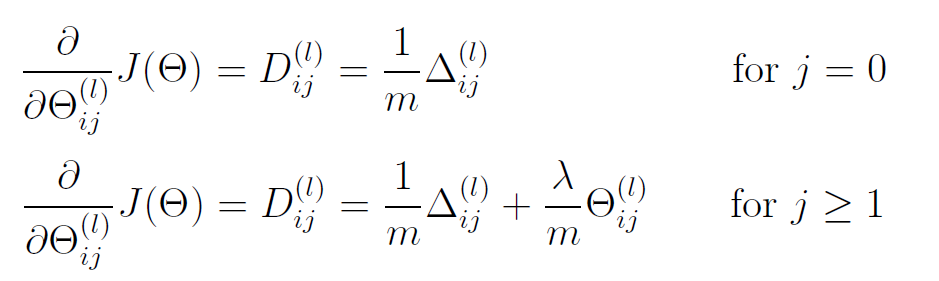

## 损失和梯度代码实现

In [26]:
def sigmoidGradient(z):
    '''
    sigmoid 的导数
    '''
    return sigmoid(z) * (1 - sigmoid(z))

def computeCost(serializeThetas, X, y, lamda=1):
    '''
    计算损失和梯度, 给 scipy.optimize.fmin_tnc 调用
    我觉得这个函数更高效
    '''
    theta1, theta2 = deserialize(serializeThetas)
    m = len(y) # number of training examples
    a0, z1, a1, z2, h = feedForward(serializeThetas, X)

    ## 计算损失
    J = -1/m*np.sum(y * np.log(h) + (1-y)*np.log(1-h))
    sum1 = np.sum(np.power(theta1[1:], 2))
    sum2 = np.sum(np.power(theta2[1:], 2))
    reg = lamda/(2*m) * (sum1+sum2)
    J += reg


    ## 计算梯度
    delta_z2 = h - y  # 第2层的梯度对代价公式的梯度 5000 * 10
    delta_z1 = delta_z2 @ theta2[:, 1:] * sigmoidGradient(z1) # 去掉偏置项, 5000*25

    theta1_grad = delta_z1.T @ a0 / m    # 25 * 401
    theta2_grad = delta_z2.T @ a1 / m    # 10 * 26

    ## regularize
    theta1_grad[1:] += lamda / m * theta1[1:] # 25 * 401
    theta2_grad[1:] += lamda / m * theta2[1:] # 10 * 26

    return J, serialize(theta1_grad, theta2_grad)


def calcCost(serializeThetas, X, y, lamda=1):
    '''
    只计算损失, 给 scipy.optimize.minimize 调用
    '''
    theta1, theta2 = deserialize(serializeThetas)
    m = len(y) # number of training examples
    a0, z1, a1, z2, h = feedForward(serializeThetas, X)

    ## 计算损失
    J = -1/m*np.sum(y * np.log(h) + (1-y)*np.log(1-h))
    sum1 = np.sum(np.power(theta1[1:], 2))
    sum2 = np.sum(np.power(theta2[1:], 2))
    reg = lamda/(2*m) * (sum1+sum2)
    J += reg

    return J


def calcGradians(serializeThetas, X, y, lamda=1):
    '''
    只计算梯度, 给 scipy.optimize.minimize 调用
    '''
    theta1, theta2 = deserialize(serializeThetas)
    m = len(y) # number of training examples
    a0, z1, a1, z2, h = feedForward(serializeThetas, X)

    ## 计算梯度
    delta_z2 = h - y  # 对代价公式的梯度 5000 * 10
    delta_z1 = delta_z2 @ theta2[:, 1:] * sigmoidGradient(z1) # 去掉偏置项, 5000*25

    theta1_grad = delta_z1.T @ a0 / m   # 25 * 401
    theta2_grad = delta_z2.T @ a1 / m   # 10 * 26

    ## regularize
    theta1_grad[1:] += lamda / m * theta1[1:]
    theta2_grad[1:] += lamda / m * theta2[1:]

    return serialize(theta1_grad, theta2_grad)

cost, thetas = computeCost(serialized_Trained_Thetas, X, y, 1)
print(cost, thetas.shape)


0.37904640005669177 (10285,)


# 预测函数

In [27]:
def predict(serializeThetas, X):
    res = feedForward(serializeThetas, X)
    h = res[-1]
    h_argmax = np.argmax(h, axis=1) # 按行返回概率最大的索引, 对应数字0 ~ 9
    return h_argmax[:, np.newaxis] # 维度变为 (5000,1)


y_pred = predict(serialized_Trained_Thetas, X)
print(y_raw.flatten())
print(y_pred.flatten())
acc = np.mean(y_pred == y_raw) # 不能直接与y比较, 因为y已经经过oneHot转换

print(f'accuracy with ready-trained weigths: {acc}') # 0.9752


[9 9 9 ... 8 8 8]
[9 9 9 ... 8 8 8]
accuracy with ready-trained weigths: 0.9752


# 训练


## minimize

`minimize` 要求损失函数和梯度函数分别作为参数传入, 所以下面我们分别创建了两个函数: `calcCost()` 和 `calcGradians()`.

这里注意到feed_forward在上面两个函数中调用, 看起来不是那么完美

In [28]:
from scipy.optimize import minimize

def nn_training_miniminze(X, y, lamda=1):
    n = X.shape[1] # X的列数401
    init_theta = np.random.uniform(-0.5, 0.5, 10285)
    result = minimize(fun = calcCost,
                      jac = calcGradians,
                      x0 = init_theta,
                      args = (X, y, lamda),
                      method = 'TNC',  # truncated Newton (TNC) algorithm
                      options={'maxiter': 200}
                      )
    print(result)
    return result['x']

lamda = 1
theta_final = nn_training_miniminze(X, y, lamda)

y_pred = predict(theta_final, X)
print(y_raw.flatten())
print(y_pred.flatten())
acc = np.mean(y_pred == y_raw)

print(f'accuracy: {acc}') # > 0.9752


     fun: 0.34566093575179274
     jac: array([-0.000857,  0.000000,  0.000000, ...,  0.000685,  0.000537,
        0.000613])
 message: 'Max. number of function evaluations reached'
    nfev: 201
     nit: 17
  status: 3
 success: False
       x: array([-0.350198, -0.474685,  0.104826, ...,  1.158356,  0.483797,
       -6.328893])
[9 9 9 ... 8 8 8]
[9 9 9 ... 8 8 8]
accuracy: 0.9906


## fmin_tnc

我比较喜欢用这个fmin_tnc, 很简洁简洁, 损失和梯度可以在一个函数返回, 减小计算量

In [29]:
from scipy.optimize import fmin_tnc

def nn_training_fmin_tnc(X, y, lamda=1):
    n = X.shape[1] # X的列数401
    init_theta = np.random.uniform(-0.5, 0.5, 10285)
    result = fmin_tnc(func=computeCost,
                      x0=init_theta,
                      maxfun=200, # max iterations
                      args=(X, y, lamda))
    print(result)
    return result[0]


lamda = 1
theta_final_2 = nn_training_fmin_tnc(X, y, lamda)

y_pred = predict(theta_final_2, X)
print(y_raw.flatten())
print(y_pred.flatten())
acc = np.mean(y_pred == y_raw)

print(f'accuracy: {acc}') # > 0.9752


(array([-1.286056,  0.021131,  0.077217, ..., -0.385348, -0.559782,
        3.304846]), 200, 3)
[9 9 9 ... 8 8 8]
[9 9 9 ... 8 8 8]
accuracy: 0.987
